Importing Required Libraries

In [1]:
import os, email
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
from nltk.tokenize.regexp import RegexpTokenizer

Loading Dataset

In [6]:
emails_df = pd.read_csv('/content/enron_spam_data.csv')
print(emails_df.shape)
emails_df.head()

(33716, 5)


,Unnamed: 0,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [8]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  33716 non-null  int64 
 1   Subject     33716 non-null  object
 2   Message     33664 non-null  object
 3   Spam/Ham    33716 non-null  object
 4   Date        33716 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


Helper Function

In [9]:
def get_text(msg):
    #To get the content from email
    parts = []
    for part in msg.walk():
        try:
            if part.get_content_type() == 'text/plain':
                parts.append( part.get_payload() )
        except:
            pass # Handle cases where content type is missing or cannot be retrieved
    return ''.join(parts)

def split_email_addresses(line):
    #To separate multiple email addresses
    if line:
        address = line.split(',')
        address = frozenset(map(lambda x: x.strip(), address))
    else:
        address = None
    return address

def preprocess_folder(data):
    folders = []
    for item in data:
        if item == None or item == '':
            folders.append(np.nan)
        else:
            item = item.split("\\")[-1]
            item = item.lower()
            folders.append(item)
    print("Folder cleaned!")
    return folders

def barplot(df, X, Y, figsize, color, orient, ylabel, xlabel, font_scale, rotation):
    f, ax = plt.subplots(figsize=figsize)
    sns.set_color_codes("muted")
    sns.barplot(x = X, y = Y, data = df, color = color, orient = orient)
    ax.set(ylabel = ylabel, xlabel = xlabel)
    sns.set(font_scale = font_scale)
    plt.xticks(rotation = rotation)
    plt.show()

Data Cleaning

In [10]:
# Check if 'Message' column exists before processing
if 'Message' in emails_df.columns:
    # Ensure the 'Message' column contains string type and fill potential NaNs
    emails_df['Message'] = emails_df['Message'].astype(str).fillna('')

    # Rename 'Message' column to 'content'
    emails_df = emails_df.rename(columns={'Message': 'content'})
else:
    # If 'Message' column doesn't exist, assume it's already renamed to 'content'
    # and ensure it's string type and fill potential NaNs if needed
    if 'content' in emails_df.columns:
        emails_df['content'] = emails_df['content'].astype(str).fillna('')
    else:
        print("Neither 'Message' nor 'content' column found.")

Number of unique values in each columns

In [11]:
print('shape of the dataframe:', emails_df.shape)
for col in emails_df.columns:
    print(col, emails_df[col].nunique())

shape of the dataframe: (33716, 5)
Unnamed: 0 33716
Subject 12773
content 15794
Spam/Ham 2
Date 1527


In [12]:
emails_df.isnull().sum()

,0
Unnamed: 0,0
Subject,0
content,0
Spam/Ham,0
Date,0


In [13]:
emails_df.duplicated().sum()

np.int64(0)

In [14]:
emails_df.columns

Index(['Unnamed: 0', 'Subject', 'content', 'Spam/Ham', 'Date'], dtype='object')

In [15]:
# index setting and dropping columns with too few values
emails_df = emails_df.set_index('Subject')
# Parsing datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)
emails_df.dtypes

/tmp/ipython-input-1932204424.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)


,0
Unnamed: 0,int64
content,object
Spam/Ham,object
Date,datetime64[ns]


Count no. of emails per user, average no. of words in subjects and message content

In [29]:
# Calculate overall average word counts
overall_avg_subject_wc = emails_df['subject_wc'].mean()
overall_avg_content_wc = emails_df['content_wc'].mean()

print(f"Overall Average Subject Word Count: {overall_avg_subject_wc:.2f}")
print(f"Overall Average Content Word Count: {overall_avg_content_wc:.2f}")

# Analyze word counts for spam vs. ham
spam_ham_word_counts = emails_df.groupby('Spam/Ham')[['subject_wc', 'content_wc']].mean()

print("\nAverage Word Counts for Spam vs. Ham:")
display(spam_ham_word_counts)

Overall Average Subject Word Count: 7.26
Overall Average Content Word Count: 357.50

Average Word Counts for Spam vs. Ham:


,subject_wc,content_wc
Spam/Ham,,
ham,6.333212,355.470233
spam,8.152408,359.463922


In [23]:
# Reset index to make 'Subject' a column again
emails_df = emails_df.reset_index()
display(emails_df.head())

,Subject,Unnamed: 0,content,Spam/Ham,Date
0,christmas tree farm pictures,0,nan,ham,1999-12-10
1,"vastar resources , inc .",1,"gary , production from the high island larger ...",ham,1999-12-13
2,calpine daily gas nomination,2,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,re : issue,3,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,meter 7268 nov allocation,4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [24]:
# Calculate word counts for 'Subject' and 'content'
emails_df['subject_wc'] = emails_df['Subject'].apply(lambda x: len(str(x).split()))
emails_df['content_wc'] = emails_df['content'].apply(lambda x: len(str(x).split()))

display(emails_df.head())

,Subject,Unnamed: 0,content,Spam/Ham,Date,subject_wc,content_wc
0,christmas tree farm pictures,0,nan,ham,1999-12-10,4,1
1,"vastar resources , inc .",1,"gary , production from the high island larger ...",ham,1999-12-13,5,1572
2,calpine daily gas nomination,2,- calpine daily gas nomination 1 . doc,ham,1999-12-14,4,8
3,re : issue,3,fyi - see note below - already done .\nstella\...,ham,1999-12-14,3,344
4,meter 7268 nov allocation,4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14,4,318


In [26]:
# Calculate word counts for 'Subject' and 'content'
emails_df['subject_wc'] = emails_df['Subject'].apply(lambda x: len(str(x).split()))
emails_df['content_wc'] = emails_df['content'].apply(lambda x: len(str(x).split()))

display(emails_df.head())

,Subject,Unnamed: 0,content,Spam/Ham,Date,subject_wc,content_wc
0,christmas tree farm pictures,0,nan,ham,1999-12-10,4,1
1,"vastar resources , inc .",1,"gary , production from the high island larger ...",ham,1999-12-13,5,1572
2,calpine daily gas nomination,2,- calpine daily gas nomination 1 . doc,ham,1999-12-14,4,8
3,re : issue,3,fyi - see note below - already done .\nstella\...,ham,1999-12-14,3,344
4,meter 7268 nov allocation,4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14,4,318


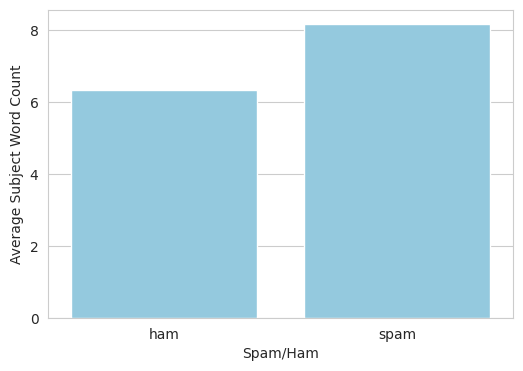

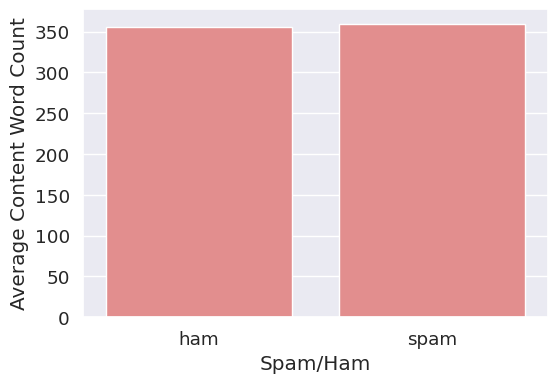

In [30]:
# Reset index to use 'Spam/Ham' as a column for plotting
spam_ham_word_counts_plot = spam_ham_word_counts.reset_index()

# Visualize average subject word count for spam vs. ham
barplot(df = spam_ham_word_counts_plot, X = "Spam/Ham", Y = "subject_wc", figsize = (6, 4), color = 'skyblue', orient = 'v', ylabel = "Average Subject Word Count", xlabel = "Spam/Ham", font_scale = 1.2, rotation = 0)

# Visualize average content word count for spam vs. ham
barplot(df = spam_ham_word_counts_plot, X = "Spam/Ham", Y = "content_wc", figsize = (6, 4), color = 'lightcoral', orient = 'v', ylabel = "Average Content Word Count", xlabel = "Spam/Ham", font_scale = 1.2, rotation = 0)

In [18]:
emails_df.isnull().sum()


,0
Unnamed: 0,0
content,0
Spam/Ham,0
Date,0


In [19]:
emails_df

,Unnamed: 0,content,Spam/Ham,Date
Subject,,,,
christmas tree farm pictures,0,nan,ham,1999-12-10
"vastar resources , inc .",1,"gary , production from the high island larger ...",ham,1999-12-13
calpine daily gas nomination,2,- calpine daily gas nomination 1 . doc,ham,1999-12-14
re : issue,3,fyi - see note below - already done .\nstella\...,ham,1999-12-14
meter 7268 nov allocation,4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
...,...,...,...,...
fw : re ivanhoe e . s . d,33711,"fyi , kim .\n- - - - - original message - - - ...",spam,2005-07-29
fw : re ivanhoe e . s . d,33712,"fyi , kim .\n- - - - - original message - - - ...",spam,2005-07-29
fw : re ivanhoe e . s . d,33713,"fyi , kim .\n- - - - - original message - - - ...",spam,2005-07-30
